In [ ]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from PIL import Image
import urllib.request
import math
import cv2
import time
import seaborn as sns
import itertools
import os
import scipy as sp
from collections import OrderedDict

#from sklearn.datasets import load_sample_image
#from sklearn.feature_extraction import image

In [ ]:
transformations = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/datasetassignmentml/fire_dataset/train',
                              transform = transformations)

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/datasetassignmentml/fire_dataset/test',
                              transform = transformations)
# eval_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/kejidataset/eval',
#                               transform = transformations)


In [ ]:
trainset = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True, drop_last=True)
testset = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

In [ ]:
net = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


In [ ]:
# freeze all the layers
for param in net.parameters():
    param.requires_grad = False

# set the final FC layer to 10 classes.
net.fc = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 4096)),
                          ('relu1', nn.ReLU()),
                          ('bn1', nn.BatchNorm1d(4096)),
                          ('fc2', nn.Linear(4096, 2048)),
                          ('relu2', nn.ReLU()),
                          ('bn2', nn.BatchNorm1d(2048)),
                          ('fc3', nn.Linear(2048, 2048)),
                          ('relu3', nn.ReLU()),
                          ('fc4', nn.Linear(2048, 1024)),
                          ('relu4', nn.ReLU()),
                          ('fc5', nn.Linear(1024, 3))
                          #('output', nn.LogSoftmax(dim=1))
                          ]))

# unfreeze the last layer so it learns on CIFAR-10.
for param in net.fc.parameters():
    param.requires_grad = True

    net.eval()

In [ ]:
# On unfreezing all the layers and set a very low learning rate the model performance is improved.

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr= 1e-5)

correct = total = 0

for i, epoch in enumerate(range(1)):
    for data in tqdm(trainset):
        X, y = data
        net.zero_grad()
        output = net(X)
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
        #loss = F.nll_loss(output, y)
        loss = loss_function(output,y)
        loss.backward()
        optimizer.step()
    print("\nTrain Accuracy: ", round((correct/total)*100, 4))

100%|██████████| 12/12 [04:00<00:00, 20.03s/it]


Train Accuracy:  75.651


In [ ]:
correct = total = 0

with torch.no_grad():
    for data in tqdm(testset):
        X, y = data
        output = net(X)
        #print(output.shape, type(output))
        for idx, i in enumerate(output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
        break

print("\nTest Accuracy: ", round((correct/total)*100, 4))

  0%|          | 0/4 [00:25<?, ?it/s]


Test Accuracy:  71.875


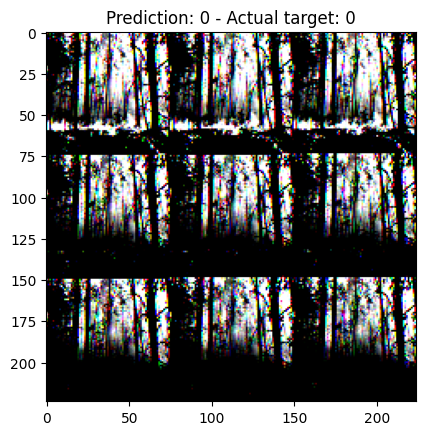

In [ ]:
net.eval()
  # Disable grad
with torch.no_grad():

    # Retrieve item
    index = 14

    # item = eval_dataset[index]
    # image = item[0]
    # print(image)
    # true_target = item[1]

    image_url = r'/content/drive/MyDrive/datasetassignmentml/fire_dataset/test/fire/fire.10.png'
    img = Image.open(image_url)
    image = transformations(img)
    true_target = 0

    # Generate prediction
    image = torch.unsqueeze(image, 0)
    #print(true_target.shape)
    prediction = net(image)

    # Predicted class value using argmax
    predicted_class = np.argmax(prediction)

    # Reshape image
    image = image.reshape(224, 224, 3)

    # Show result
    plt.imshow(image)
    plt.title(f'Prediction: {predicted_class} - Actual target: {true_target}')
    plt.show()